# Imágenes Biomédicas. Proyecto 1.
Imagenes en difusión de hidrógeno.

**Diego Moreno**

Importamos las librerías:

In [286]:
import dipy
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import leastsq

Librerías del tutorial:

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.reconst.dti as dti
from dipy.data import get_fnames
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.data import get_sphere
from dipy.viz import window, actor

# A) y B) Realizamos el tutorial con los datos proporcionados 

Leemos los datos:

In [3]:
data3 = pd.read_csv('NODDI_DWI.scheme', sep='\n', engine='python', header=None).loc[:,0]

In [4]:
data = [np.array(data3[i].split()).astype(np.float64).tolist()\
        for i in range(1,len(data3))]
data = np.array(data)

Función para obtener los valores de $b$.

In [67]:
def get_bvals(G, DELTA, delta):
    #Definir gyromagnetic ratio:
    gmr = 2*np.pi*42.576*1e6 #de MHZ/T -> rad/(sec T)
    bval = (gmr * delta * G)**2 * (DELTA - delta/3)  # en s/m^2
    return bval

Llenamos la tabla del gradiente:

In [443]:
bvals = get_bvals(data[:, 3], data[:, 4], data[:, 5])
# Solo con valores 700 de b
idx = bvals == bvals[1] # Es un valor de 700
idx[0] = True # Valor 0
bvals = bvals[idx]
bvecs = data[:, :3][idx]
gtab = gradient_table(bvals, bvecs)

Cargamos los datos de los valores S:

In [444]:
maskdata, affine = load_nifti('NODDI_DWI.nii')
mask, affine2 = load_nifti('BRAIN_MASK.nii')

In [445]:
maskdata = maskdata.squeeze(3)
# Seleccionamos solamente los de b=700
maskdata = maskdata[:, :, :, idx]

Ajustamos el modelo con la tabla de gradiente dada:

In [446]:
tenmodel = dti.TensorModel(gtab)

In [447]:
tenfit = tenmodel.fit(maskdata)

Calculamos la fractional anisotropy (FA) con la función dada por Dipy. Más adelante se compararán los valores de ésta con la función programada propiamente.

In [448]:
print('Computing anisotropy measures (FA, MD, RGB)')

FA = fractional_anisotropy(tenfit.evals)

Computing anisotropy measures (FA, MD, RGB)


In [449]:
FA[np.isnan(FA)] = 0

Guardamos los valores en un archivo nifti:

In [249]:
save_nifti('tensor_fa.nii.gz', FA.astype(np.float32), affine2)

In [250]:
save_nifti('tensor_evecs.nii.gz', tenfit.evecs.astype(np.float32), affine2)

In [251]:
MD1 = dti.mean_diffusivity(tenfit.evals)
save_nifti('tensors_md.nii.gz', MD1.astype(np.float32), affine2)

In [252]:
MD2 = tenfit.md

In [253]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)
save_nifti('tensor_rgb.nii.gz', np.array(255 * RGB, 'uint8'), affine2)

Imprimimos unas imágenes a manera de ejemplo dadas por el ajuste del tensor de difusión anterior:

In [254]:
print('Computing tensor ellipsoids in a part of the splenium of the CC')

sphere = get_sphere('repulsion724')

# Enables/disables interactive visualization
interactive = False

ren = window.Scene()

#evals = tenfit.evals[20:50, 90:, 9:10]
#evecs = tenfit.evecs[20:50, 90:, 9:10]
evals = tenfit.evals[:128, :128, 9:10]
evecs = tenfit.evecs[:128, :128, 9:10]

Computing tensor ellipsoids in a part of the splenium of the CC


In [255]:
#cfa = RGB[20:50, 90:, 9:10]
cfa = RGB[:128, :128, 9:10]
cfa /= cfa.max()

ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa,
                            sphere=sphere, scale=.5))

print('Saving illustration as tensor_ellipsoids.png')
window.record(ren, n_frames=1, out_path='tensor_ellipsoids.png',
              size=(1200, 1200))
if interactive:
    window.show(ren)
    
ren.clear()

Saving illustration as tensor_ellipsoids.png


Mostramos la imagen generada:

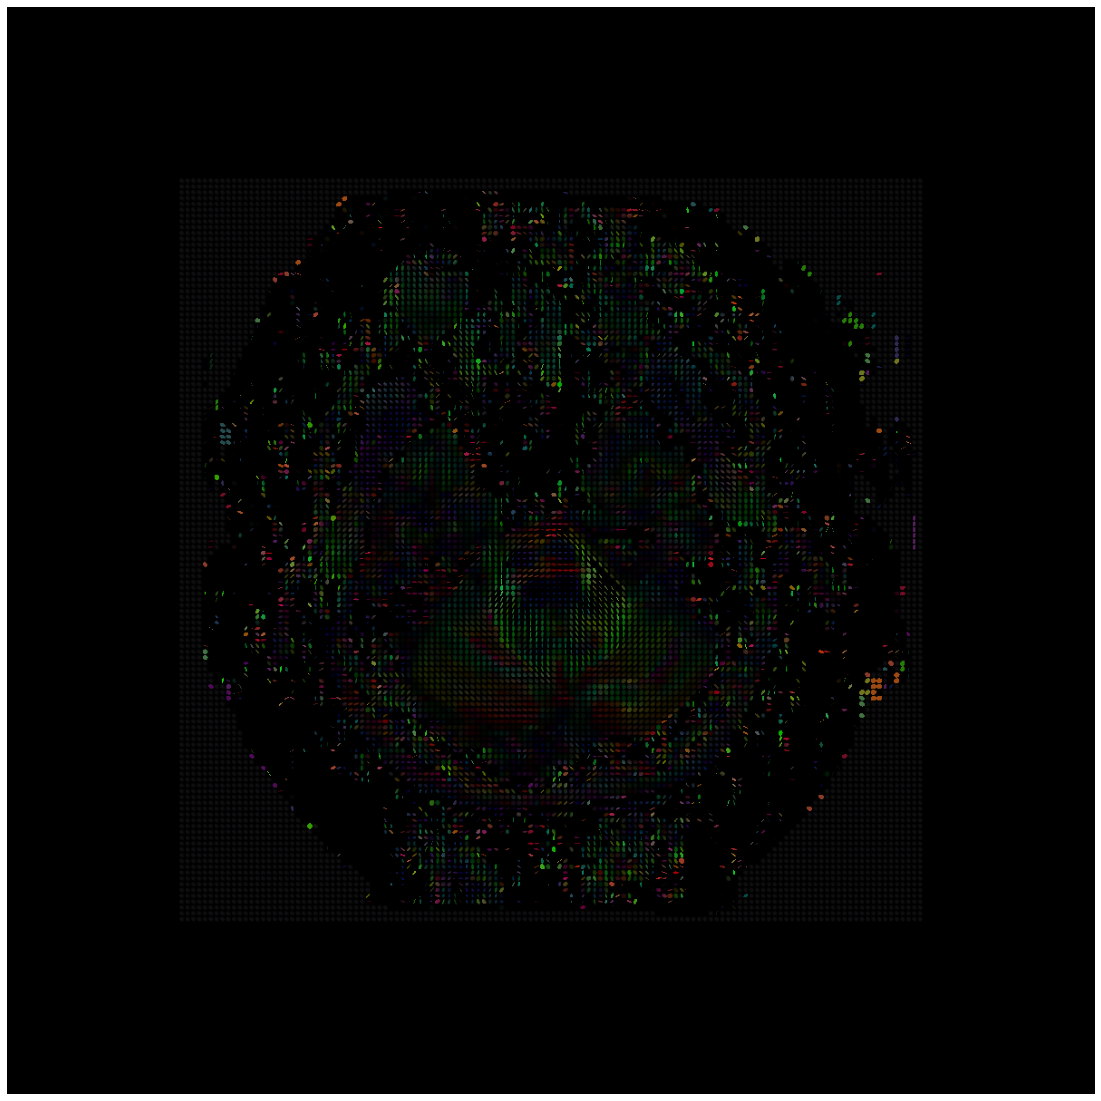

In [466]:
img = plt.imread('tensor_ellipsoids.png')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.axis('off')
plt.show()

Ahora generamos la misma imagen pero con esferas con objetos dirigidos:

In [259]:
#tensor_odfs = tenmodel.fit(maskdata[20:50, 55:85, 38:39]).odf(sphere)
#tensor_odfs = tenmodel.fit(maskdata[20:50, 90:, 9:10]).odf(sphere)
tensor_odfs = tenmodel.fit(maskdata[:128, :128, 9:10]).odf(sphere)

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=.5,
                             colormap=None)
ren.add(odf_actor)
print('Saving illustration as tensor_odfs.png')
window.record(ren, n_frames=1, out_path='tensor_odfs.png', size=(1200, 1200))
if interactive:
    window.show(ren)
    
ren.clear()

Saving illustration as tensor_odfs.png


Mostramos la imagen generada:

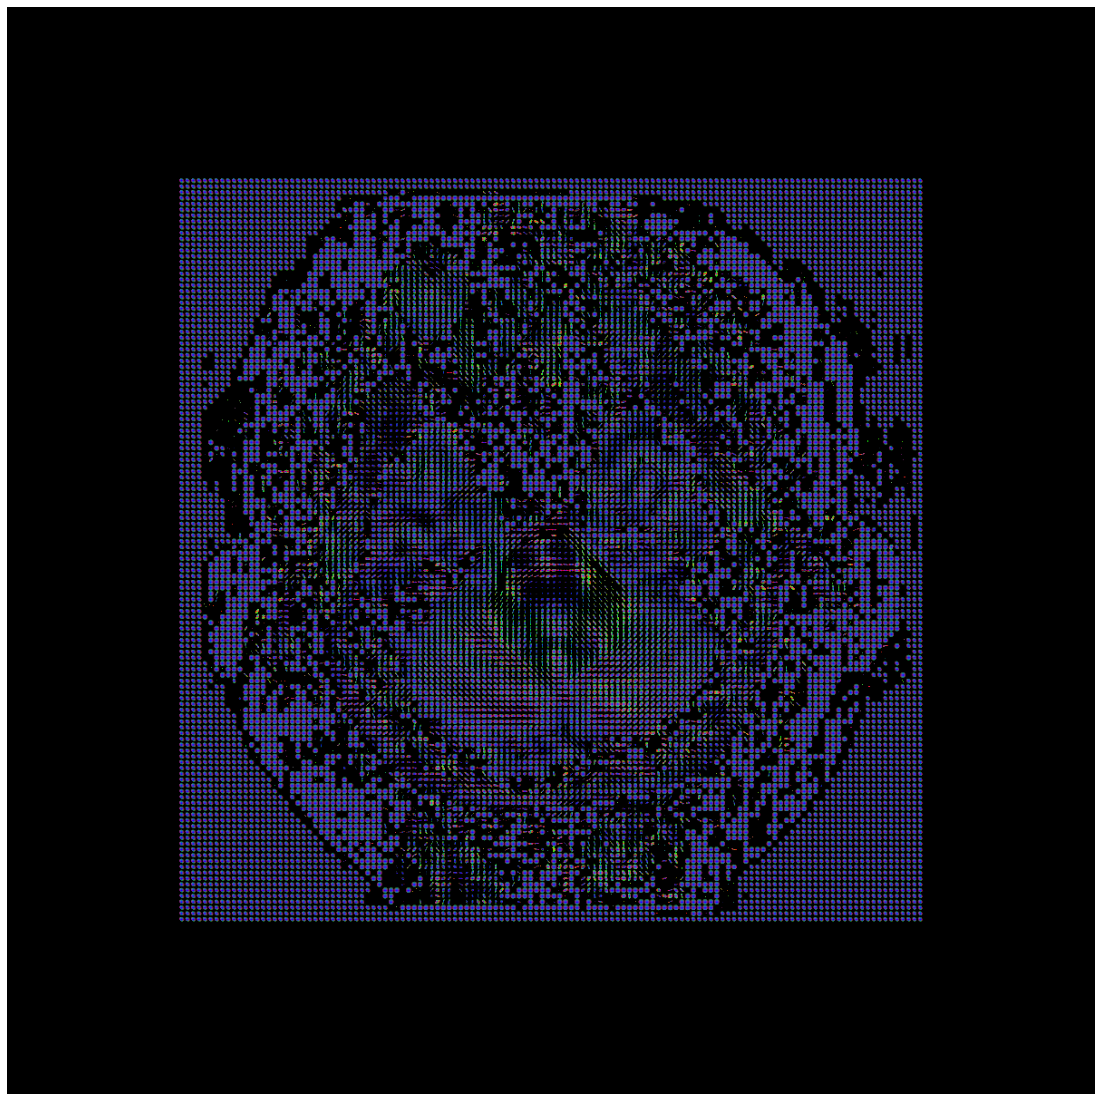

In [467]:
img = plt.imread('tensor_odfs.png')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.axis('off')
plt.show()

# C) Definimos nuestro ajuste del tensor de difusión por mínimos cuadrados y que calcula automáticamente el FA.

Guardamos los valores globales de S, G y b

In [296]:
S = maskdata.copy()
G = bvecs.copy()
b = bvals.copy()

Definimos las funciones:

In [437]:
def f(d, Sˆ, g_i):
    D = reshape(d)
    #D = d.reshape((3,3))
    aux = [g_i[i]@D@g_i[i] for i in range(g_i.shape[0])]
    return Sˆ - aux

def reshape(d):
    D = np.zeros((3,3), dtype=np.float64)
    D[0,0] = d[0]
    D[0,1] = D[1,0] = d[1]
    D[0,2] = D[2,0] = d[2]
    D[1,1] = d[3]
    D[1,2] = D[2,1] = d[4]
    D[2,2] = d[5]
    return D

def get_FA(evals):
    ans = (evals[0]-evals[1])**2 + (evals[0]-evals[2])**2 + (evals[1]-evals[2])**2
    ans /= (evals[0])**2 + (evals[1])**2 + (evals[2])**2
    ans = np.sqrt(ans/2)
    return ans

def tensor_diffusion_fit():
    n, m, l, _ = S.shape
    TD_FA = np.zeros((n,m,l), dtype=np.float64)
    for i in range(n):
        for j in range(m):
            for k in range(l):
                if S[i,j,k,0] != 0:
                    idx = S[i,j,k, 1:25] != 0
                    if sum(idx) >= 6:
                        S_aux = S[i,j,k, 1:25][idx]
                        S_hat = np.log(S_aux)-np.log(S[i,j,k, 0])
                        S_hat /= -b[1:25][idx]
                        # Ajuste por minimos cuadrados
                        d = leastsq(func=f, x0=np.zeros(6, dtype=np.float64), 
                                    args=(S_hat, G[1:][idx]))
                        #d = d[0].reshape((3,3))
                        d = reshape(d[0])
                        ev = np.linalg.eigvals(d)
                        TD_FA[i,j,k] = get_FA(ev).astype(np.float64)
    return TD_FA
                    

Ajustamos el modelo y obtenemos los valores de FA:

In [438]:
TD_FA = tensor_diffusion_fit()

<ipython-input-437-efabf27c35ca>:19: RuntimeWarning: invalid value encountered in double_scalars
  ans /= (evals[0])**2 + (evals[1])**2 + (evals[2])**2


In [441]:
TD_FA[np.isnan(TD_FA)] = 0

### Realizamos un scatter plot para algunos vóxeles y así comparar el dado por la función de Dipy y el nuestro:

In [479]:
ax, ay, az = 40, 45, 35

Ejemplo para el eje x, correspondiente a lo ancho de la imagen:

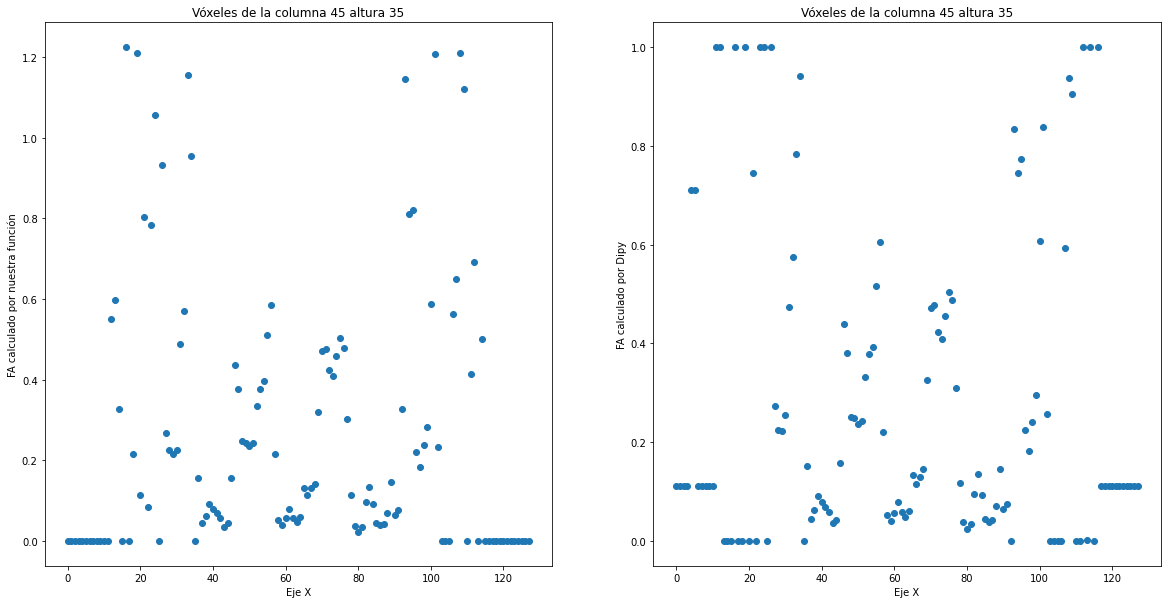

In [476]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(np.linspace(0,128,128, endpoint=False), TD_FA[:,ay,az])
plt.title('Vóxeles de la columna %d altura %d' % (int(ay), int(az)))
plt.xlabel('Eje X')
plt.ylabel('FA calculado por nuestra función')
plt.subplot(122)
plt.scatter(np.linspace(0,128,128, endpoint=False), FA[:,ay,az])
plt.title('Vóxeles de la columna %d altura %d' % (int(ay), int(az)))
plt.xlabel('Eje X')
plt.ylabel('FA calculado por Dipy')
plt.show()

Algunos valores de la FA para algunos vóxeles a lo largo de la imagen (eje Y):

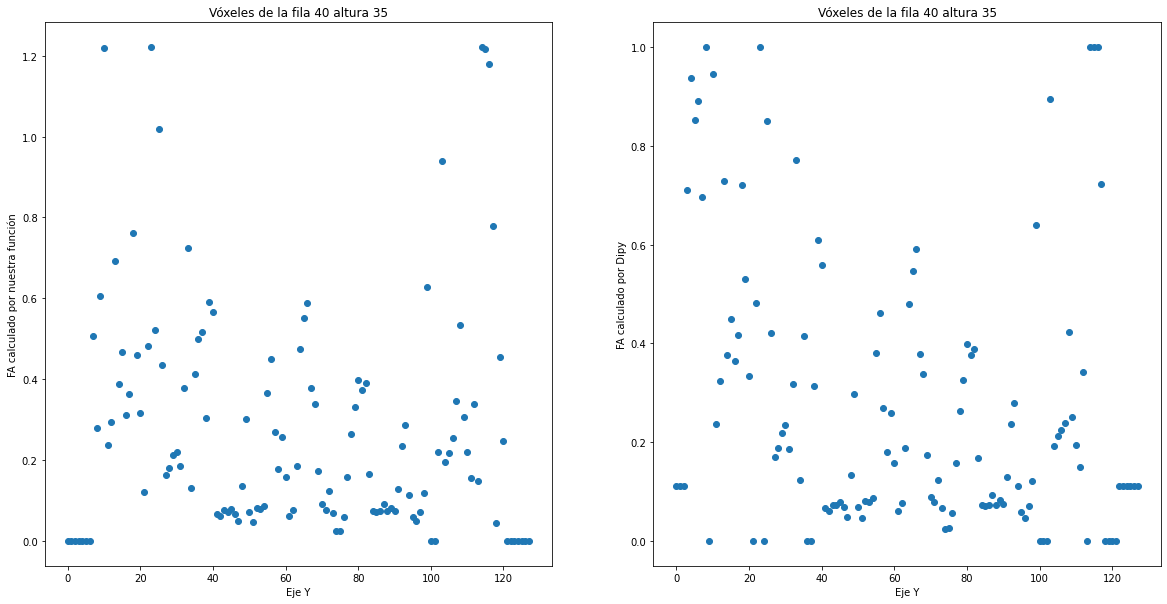

In [480]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(np.linspace(0,128,128, endpoint=False), TD_FA[ax,:,az])
plt.title('Vóxeles de la fila %d altura %d' % (int(ax), int(az)))
plt.xlabel('Eje Y')
plt.ylabel('FA calculado por nuestra función')
plt.subplot(122)
plt.scatter(np.linspace(0,128,128, endpoint=False), FA[ax,:,az])
plt.title('Vóxeles de la fila %d altura %d' % (int(ax), int(az)))
plt.xlabel('Eje Y')
plt.ylabel('FA calculado por Dipy')
plt.show()

Finalmente, los valores de FA, para algunos vóxeles a lo largo de la altura en las imagenes (eje Z):

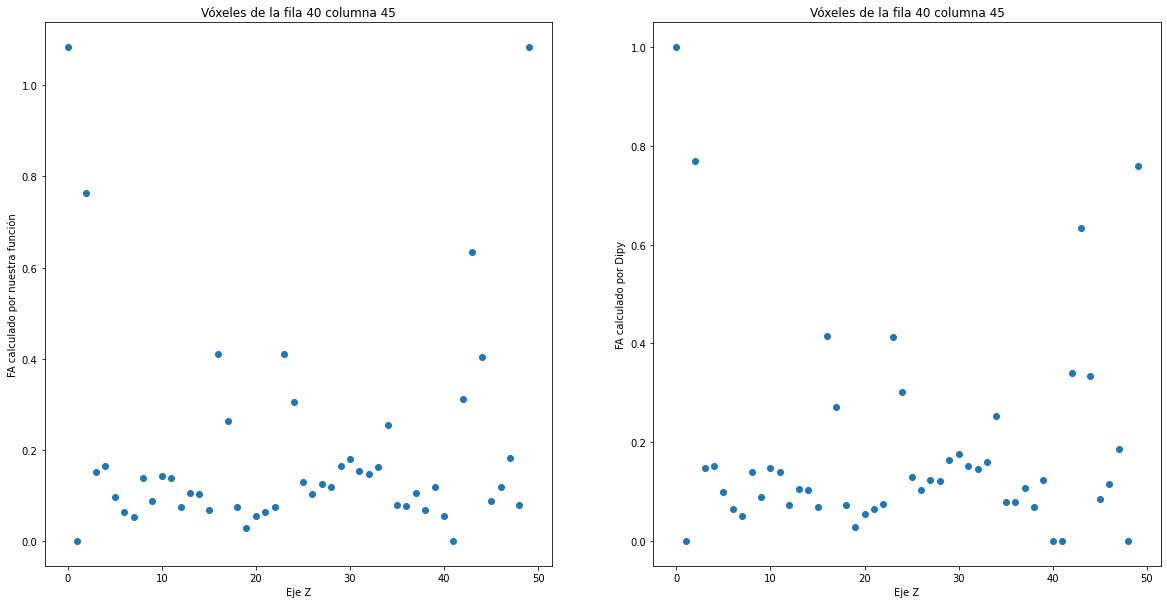

In [482]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(np.linspace(0,50,50, endpoint=False), TD_FA[ax,ay,:])
plt.title('Vóxeles de la fila %d columna %d' % (int(ax), int(ay)))
plt.xlabel('Eje Z')
plt.ylabel('FA calculado por nuestra función')
plt.subplot(122)
plt.scatter(np.linspace(0,50,50, endpoint=False), FA[ax,ay,:])
plt.title('Vóxeles de la fila %d columna %d' % (int(ax), int(ay)))
plt.xlabel('Eje Z')
plt.ylabel('FA calculado por Dipy')
plt.show()

Como resultado de la comparación de algunos scatter plot para algunos vóxeles de los valores de FA dados por nuestra función y de los dados por la función de Dipy, podemos decir a grandes rasgos, que las gráficas son muy parecidas pues conservan algunas estructuras en puntos cercanos y muchas veces se aprecian «dibujos» del scatter plot similares. Por lo que es una buena medida para ver que nuestra función realiza las cosas bien.